In [1]:
import warnings
import pyodbc
import numpy as np
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import datetime
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    #train_size = int(len(X) * 0.66)
    #train, test = X[0:train_size], X[train_size:]
    train, test = X[0:-12], X[-12:]    
    history = [x for x in train]
    # make predictions
    predictions = list()
    
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    for t in range(len(test)):
#        model = ARIMA(history, order=arima_order)
#        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [3]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset,pdq, seasonal_pdq):
    dataset = dataset.astype('float32')
    best_aic, best_param, best_param_seasonal = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
#                print(param,param_seasonal)
                mod = sm.tsa.statespace.SARIMAX(dataset,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                aic = results.aic
                if best_aic > aic:
                    best_aic = aic
                    best_param = param
                    best_param_seasonal = param_seasonal
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            except:
                    continue
    return best_param, best_param_seasonal

In [4]:
series = pd.read_csv('C:\Python\CRM Win_Loss\Time Series\ILM Time series - All - 15062017.csv',encoding="cp1252")

In [5]:
min_count = 45

# find centre with more than 12 values
centre_lists = pd.DataFrame(series.centre_no.unique().tolist())
centre_lists.columns = ['centre_no']
centre_count = series.centre_no.value_counts()
centre_lists_min = centre_lists[centre_lists["centre_no"].isin(centre_count[centre_count>=min_count].index)]
centre_lists_final = centre_lists_min['centre_no'].tolist()

In [6]:
# make 0 value for whole month if doesn't exists
series_t1 = series.pivot(index='centre_no',columns='Year_Month',values='Fee Income')
series_t1 = series_t1.replace(np.nan, 0, regex=True)
series_t1
series_t1['centre_no'] = series_t1.index
#series_t1.reset_index(level=0, inplace=True)
series_t2 = pd.melt(series_t1,id_vars=['centre_no'])
series_t2.columns = ['centre_no','Year_Month','Fee Income']
# filter data which exists in centre_lists_final
series_final = series_t2[series_t2["centre_no"].isin(centre_lists_final)]

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [8]:
warnings.filterwarnings("ignore")

# Evaluation of times series for each centres - Test
ctr_list = []   
param_list = []
param_seasonal_list = []
series1 = series_final[series_final.centre_no == 'All']
series1['Year_Month'] = pd.to_datetime(series1['Year_Month'])
series1.set_index('Year_Month',inplace=True)
series1 = series1.sort_index()
series1 = series1[['Fee Income']]

In [9]:
best_aic, best_param, best_param_seasonal = float("inf"), None, None
dataset = series1.values
param = pdq[1]
param_seasonal = seasonal_pdq[1]
print(param,param_seasonal)
mod = sm.tsa.statespace.SARIMAX(dataset,
                                order=param)
#                                seasonal_order=param_seasonal,
#                                enforce_stationarity=False,
#                                enforce_invertibility=False)
results = mod.fit()
aic = results.aic
print(aic)

(0, 0, 1) (0, 0, 1, 12)
1322.02995353


In [10]:
param_result, param_seasonal_result = evaluate_models(series1.values, pdq, seasonal_pdq )
print(param_result,param_seasonal_result)

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7304541.822013127
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:880.8678320734358
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:857.6973208529162
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:550.036746465713
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1262.9838379774899
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5550484.021039025
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:827.7980948620334
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:961.4001585748681
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:905.4831359372344
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:555.1636812414956
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:447918.59459740936
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:860.6258475154209
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:311475.87474222283
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:531.3299131574869
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1118.092863036532
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:806.9619121319278
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:848.5328713402428
ARIMA(0, 1, 1)x(1, 0, 

In [11]:
series1 = series_final[series_final.centre_no == 'All']
series1['Year_Month'] = pd.to_datetime(series1['Year_Month'])
series1.set_index('Year_Month',inplace=True)
series1 = series1.sort_index()
series1 = series1[['Fee Income']]

best_aic, best_param, best_param_seasonal = float("inf"), None, None
dataset = series1.values
param = (1,1,0)
param_seasonal = (1,1,0,12)

mod = sm.tsa.statespace.SARIMAX(dataset,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
aic = results.aic
print(aic)
print(results.summary().tables[1])

507.310787616
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5204      0.560     -0.929      0.353      -1.618       0.577
ar.S.L12      -0.3284      0.411     -0.799      0.424      -1.134       0.477
sigma2      2.921e+10      4e-12   7.31e+21      0.000    2.92e+10    2.92e+10


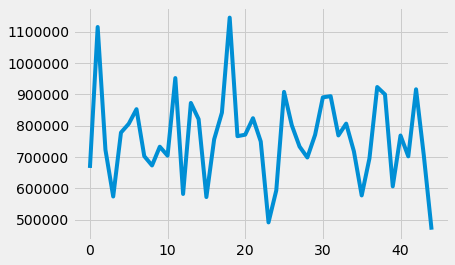

In [12]:
plt.figsize=(15,12)
plt.plot(dataset.tolist())

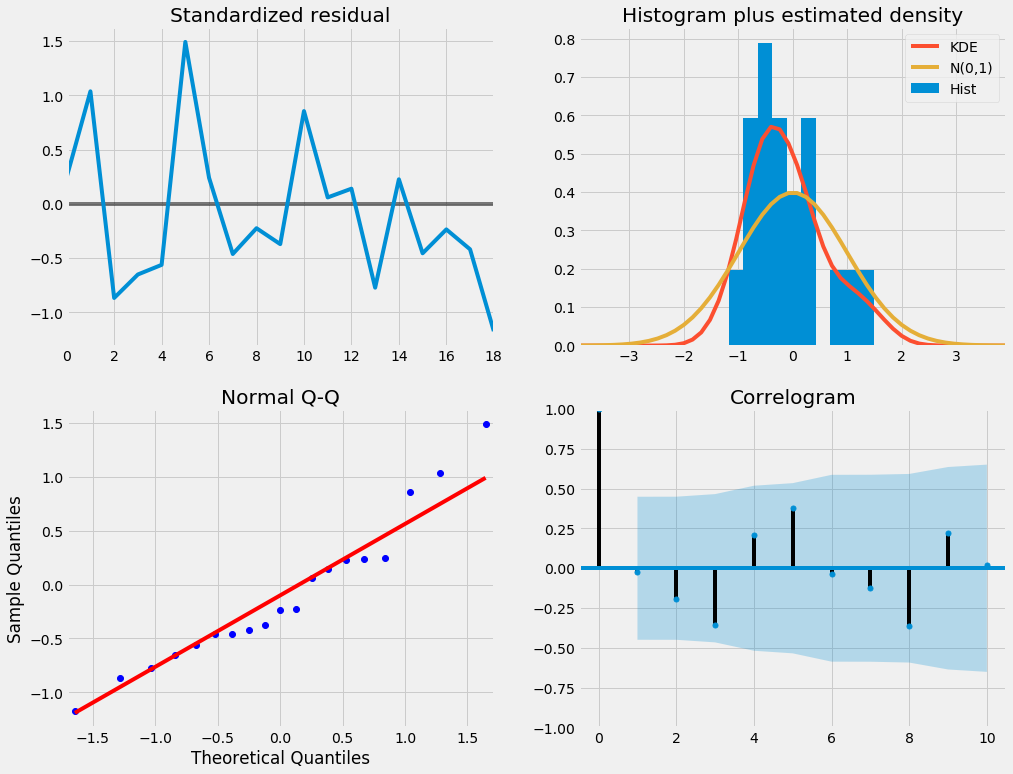

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [14]:
startd = pd.to_datetime('2017-01-01')
endd = pd.to_datetime('2017-05-01')
#pred = results.get_prediction(start=startd, end = endd,dynamic=False)
pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower y,upper y
0,-3394.757202,3.394757e+03
1,214899.170245,8.848511e+05
2,545754.777885,1.215708e+06
3,591797.894374,1.261751e+06
4,316717.039856,9.866700e+05


In [15]:
results.summary().tables[2]

Ljung-Box (Q):,27.16,Jarque-Bera (JB):,1.75
Prob(Q):,0.08,Prob(JB):,0.42
Heteroskedasticity (H):,0.51,Skew:,0.74
Prob(H) (two-sided):,0.43,Kurtosis:,3.01


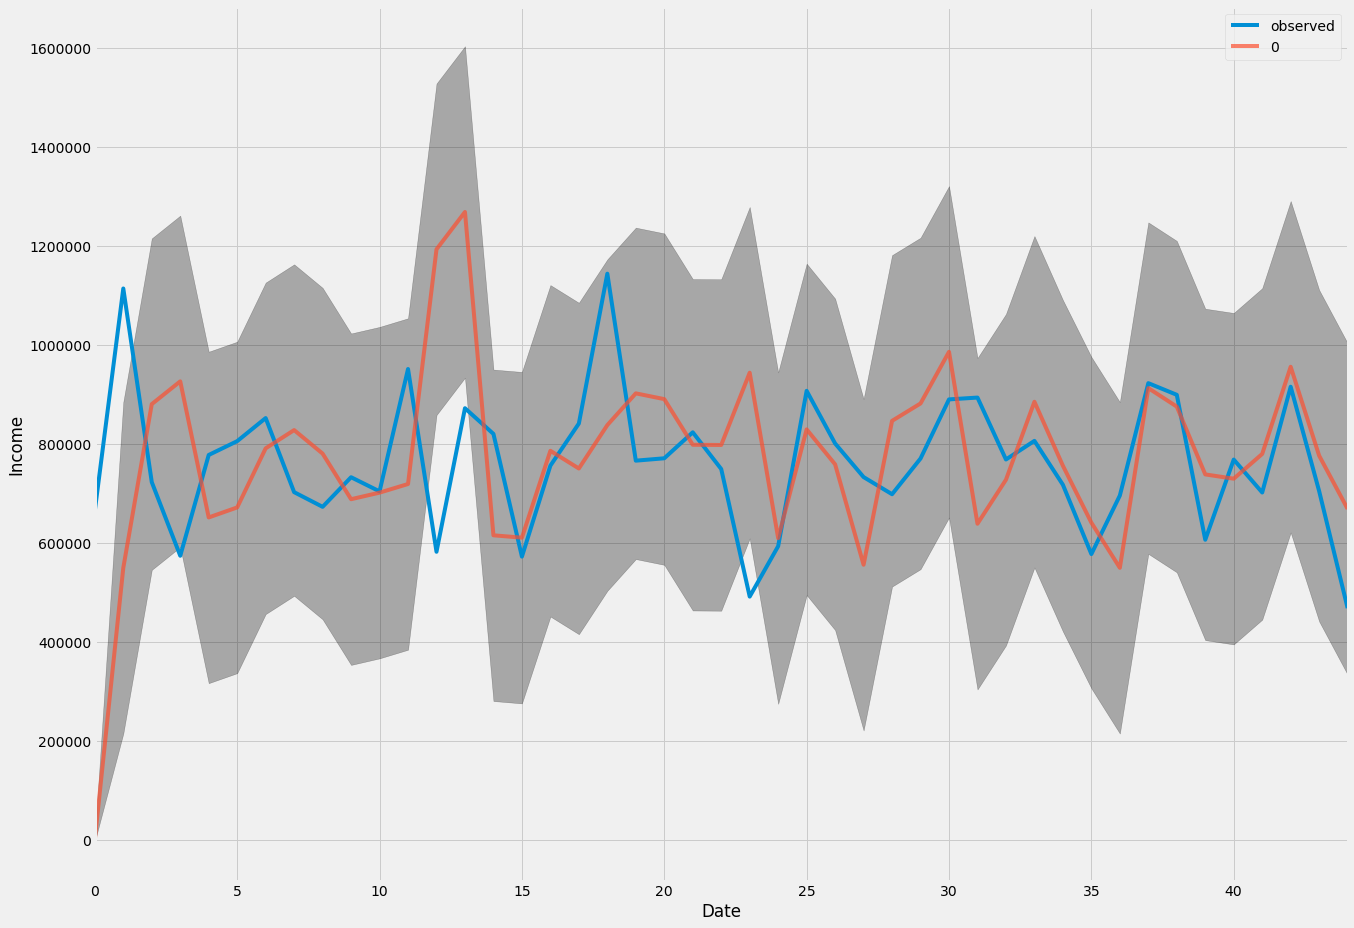

In [16]:
series1_pl = series1.reset_index()['Fee Income']
ax = series1_pl.plot(label='observed',figsize=(20,15))
pd.DataFrame(pred.predicted_mean).plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Income')
plt.legend()
#plt.figure(figsize=(20,15))
#plt.show()

In [17]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

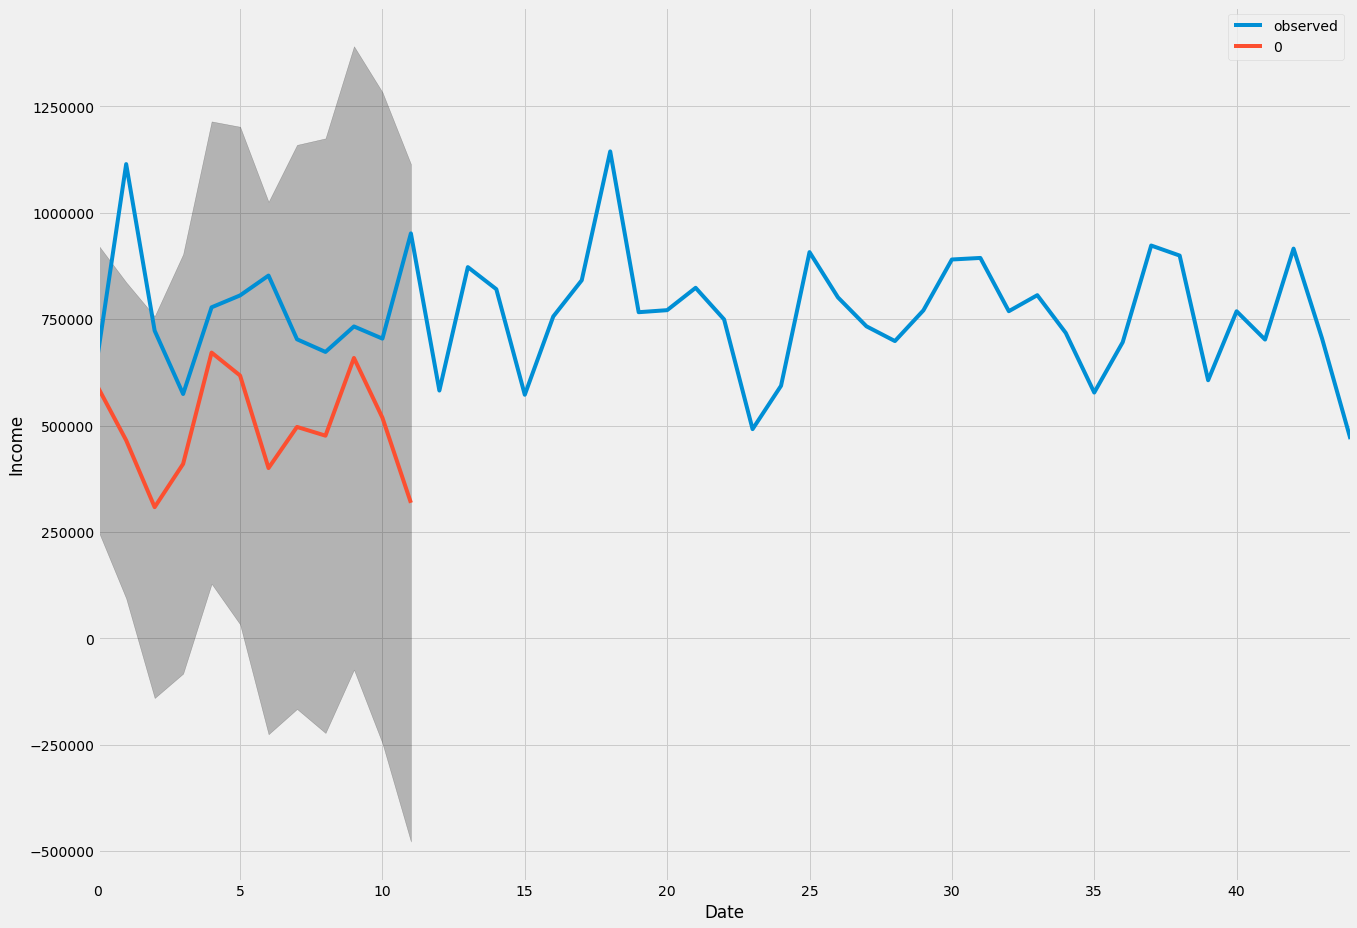

In [18]:
ax = series1_pl.plot(label='observed',figsize=(20, 15))
pd.DataFrame(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Income')

plt.legend()

In [19]:
pred_ci

,lower y,upper y
0,256106.838703,9.260337e+05
1,93894.206713,8.368826e+05
2,-140198.637385,7.568874e+05
3,-82841.809965,9.027939e+05
4,128258.834877,1.214873e+06
5,33042.894962,1.202335e+06
6,-225362.431759,1.025808e+06
7,-165979.243845,1.159726e+06
8,-222375.577892,1.175027e+06
9,-73591.324977,1.391440e+06
